# 1. Image Processing
In this exercise, you will:

✅ Load an image

✅ Apply noise filtering techniques (Gaussian Blur, Median Filter)

✅ Perform edge detection using Sobel, Prewitt, and Canny

✅ Compare the results

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # For displaying images in Colab

**Upload an image**

In [7]:
# Upload an image
#Convert it to grayscale for edge detection

image_path = '/content/Lena.jpg'
img = cv2.imread(image_path)


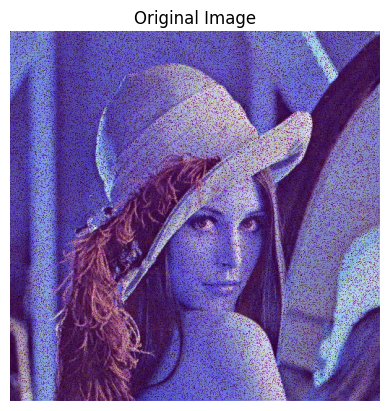

Image Shape: (512, 512, 3)


In [8]:
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()
print("Image Shape:", img.shape) # Output: (height, width, channels)

Why the color changed???

Because OpenCV (cv2) loads images in BGR (Blue, Green, Red) format by default

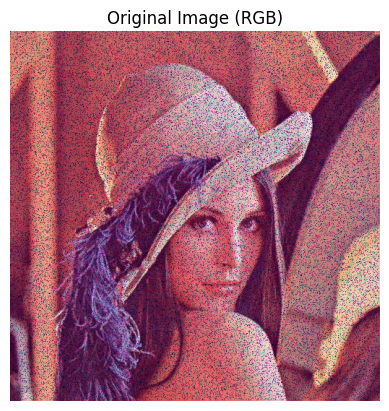

In [9]:
#Change back to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)  # Display the converted image
plt.title("Original Image (RGB)")
plt.axis('off')
plt.show()

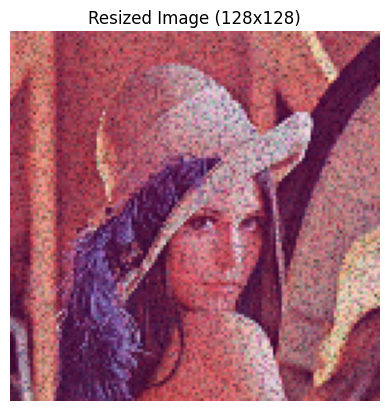

Image Shape: (128, 128, 3)


In [10]:
# Resize image to 128x128 pixels
resized_image = cv2.resize(img_rgb, (128, 128))

# Display the resized image
plt.imshow(resized_image)
plt.title("Resized Image (128x128)")
plt.axis('off')
plt.show()
print("Image Shape:", resized_image.shape) # Output: (height, width, channels)

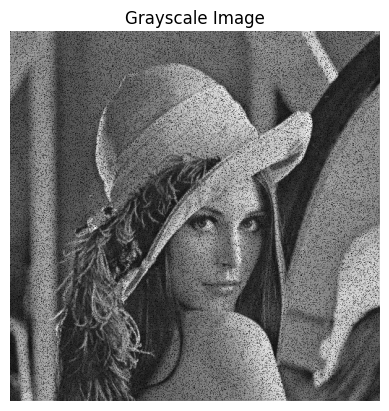

Image Shape: (512, 512)


In [11]:
#convert to gray scale

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Display the grayscale image
plt.imshow(img_gray, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title("Grayscale Image")
plt.axis('off')
plt.show()
print("Image Shape:", img_gray.shape) # Output: (height, width)


**Apply Noise Filtering**

Gaussian Blur: smooths the image by reducing noise

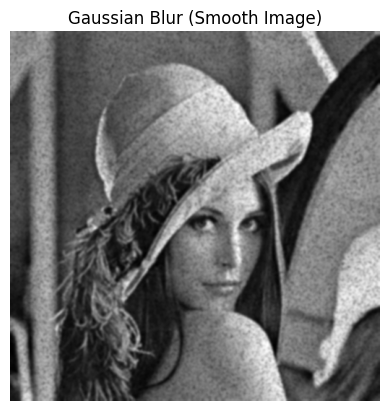

In [12]:
gaussian_blur = cv2.GaussianBlur(img_gray, (7, 7), 0)

plt.imshow(gaussian_blur, cmap='gray')
plt.title("Gaussian Blur (Smooth Image)")
plt.axis('off')
plt.show()

Median Filter (Better for Removing Salt-and-Pepper Noise)

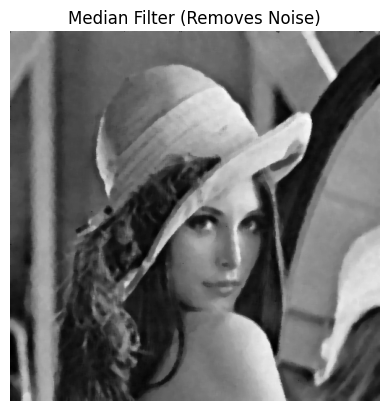

In [13]:
median_blur = cv2.medianBlur(img_gray, 7)

plt.imshow(median_blur, cmap='gray')
plt.title("Median Filter (Removes Noise)")
plt.axis('off')
plt.show()

Canny Edge Detection (Best for Strong Edges)

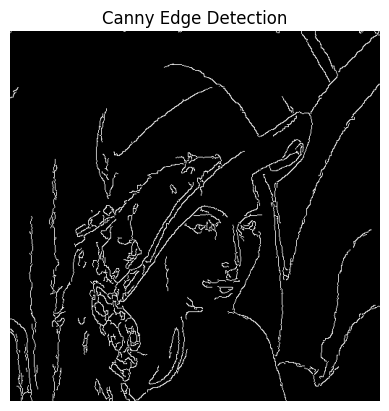

In [14]:
canny_edges = cv2.Canny(median_blur, 50, 150)

plt.imshow(canny_edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()

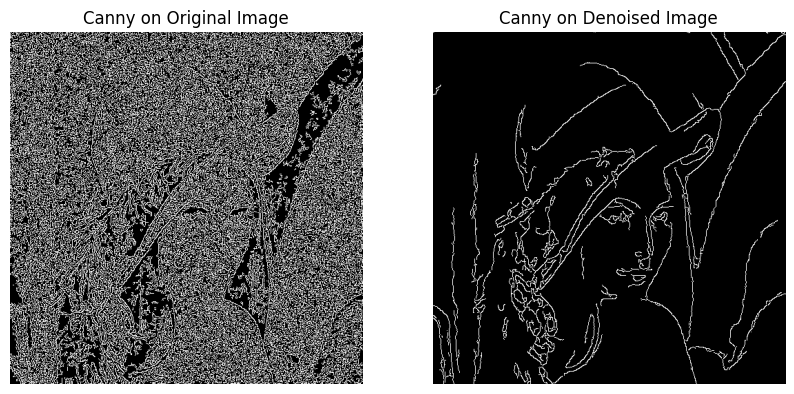

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.Canny(img_gray, 50, 150), cmap='gray'); axs[0].set_title("Canny on Original Image")
axs[1].imshow(cv2.Canny(median_blur, 50, 150), cmap='gray'); axs[1].set_title("Canny on Denoised Image")
for ax in axs: ax.axis('off')
plt.show()

 Image Augmentation


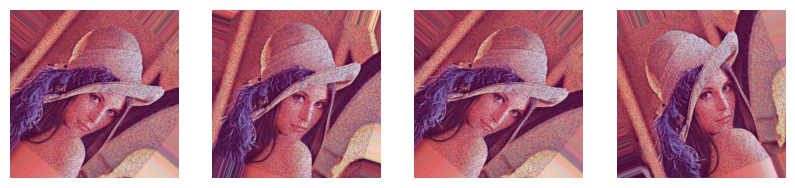

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load an example image
image = cv2.imread("/content/Lena.jpg")  # Change to your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Create ImageDataGenerator with rotation range
datagen = ImageDataGenerator(rotation_range=45)  # Rotate up to ±45 degrees

# Generate rotated images
augmented_images = datagen.flow(image, batch_size=1)

# Show 4 rotated images
plt.figure(figsize=(10, 5))
for i in range(4):
    batch = next(augmented_images)  # Correct way to get the next batch
    plt.subplot(1, 4, i+1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
plt.show()


# 2. Convolutional Neural Network (CNN)

Dataset: CIFAR-10 (Canadian Institute for Advanced Research, 10 classes)
Dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
There are 50000 training images and 10000 test images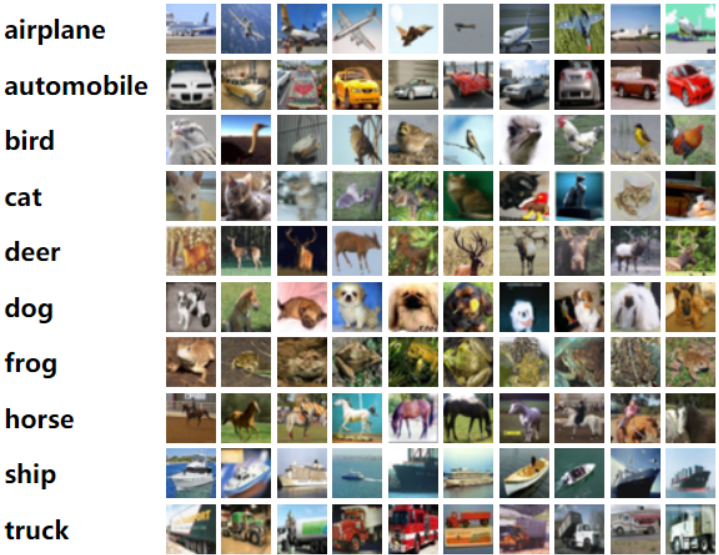

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Import TensorFlow


In [18]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Download and prepare the CIFAR10 dataset

In [19]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
# Check dataset shape
print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Test set: {test_images.shape}, Labels: {test_labels.shape}")

Training set: (50000, 32, 32, 3), Labels: (50000, 1)
Test set: (10000, 32, 32, 3), Labels: (10000, 1)


In [21]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

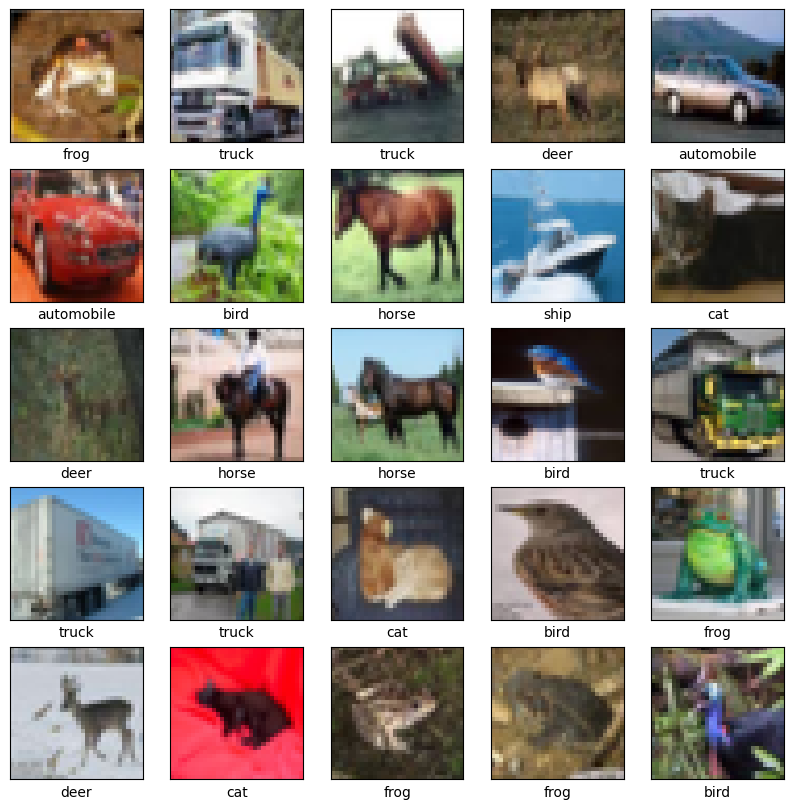

In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width,color_channels), ignoring the batch size. In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [25]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

Compile and train the model

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.3621 - loss: 1.7298 - val_accuracy: 0.5373 - val_loss: 1.2683
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 50ms/step - accuracy: 0.5781 - loss: 1.1875 - val_accuracy: 0.6285 - val_loss: 1.0430
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.6390 - loss: 1.0144 - val_accuracy: 0.6475 - val_loss: 1.0045
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.6794 - loss: 0.9117 - val_accuracy: 0.6776 - val_loss: 0.9286
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.7126 - loss: 0.8217 - val_accuracy: 0.6901 - val_loss: 0.8841
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.7348 - loss: 0.7621 - val_accuracy: 0.6908 - val_loss: 0.8927
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 90s 52ms/step - accuracy: 0.7507 - loss: 0.7082 - val_accuracy: 0.7044 - val_loss: 0.8651
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.7670 -

Evaluate the model

313/313 - 6s - 20ms/step - accuracy: 0.6986 - loss: 0.9189


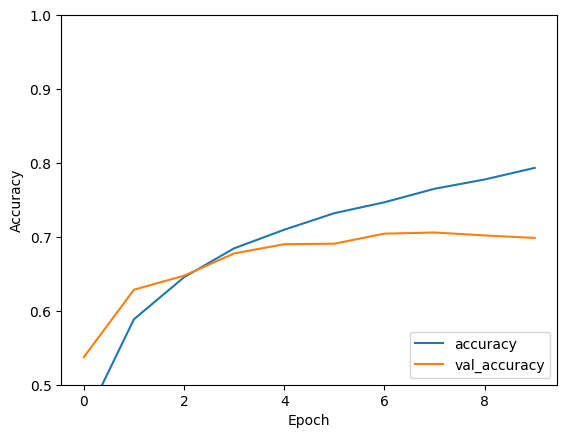

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [29]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions on the test data
predictions = np.argmax(model.predict(test_images), axis=-1)

# Print the classification report
print(classification_report(test_labels, predictions, target_names=class_names))


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
              precision    recall  f1-score   support

    airplane       0.59      0.85      0.70      1000
  automobile       0.86      0.78      0.82      1000
        bird       0.63      0.56      0.59      1000
         cat       0.50      0.54      0.52      1000
        deer       0.69      0.62      0.65      1000
         dog       0.63      0.59      0.61      1000
        frog       0.88      0.68      0.76      1000
       horse       0.70      0.80      0.75      1000
        ship       0.80      0.81      0.80      1000
       truck       0.84      0.76      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

